In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import osr
import math
import numpy as np
from osgeo import gdal

%matplotlib inline

# global variables
spectral_bands = ['blue','green','red','nir','swir1','swir2']
temporal_features = [28,36,52,56,73,84,91,104,109,112,140,146,156,168,182,196,208,219,224,252,255,260,273,280,292,308,312,328,336]


def save_geotiff(ds,fname):
    
    dst_ds = gdal.GetDriverByName('GTiff').CreateCopy(fname+'.tif', ds)
    dst_ds = None


# function to read in a data cube from a geo tiff file
def geotiff_to_datacube(ds):
    
    geotransform = ds.GetGeoTransform()
    
    proj = osr.SpatialReference(wkt=ds.GetProjection())
    epsg = int(proj.GetAttrValue('AUTHORITY',1))
    
    xy_shape = np.array(ds.GetRasterBand(1).ReadAsArray()).shape
    
    # get number of bands in raster file
    n_bands = ds.RasterCount
    
    # initialize a data cube
    xyz_shape = xy_shape + (n_bands,)
    data_cube = np.ndarray(xyz_shape)
    
    # fill it with bands
    for i in range(1,n_bands+1):
        data_cube[:,:,i-1] =  np.array(ds.GetRasterBand(i).ReadAsArray())
    
    return data_cube, geotransform, epsg
    # end of read in datacube function


def datacube_to_geotiff(data_cube,geotransform,epsg):
    
    n_rows, n_cols, n_bands = data_cube.shape
    
    # open geo tiff file
    ds = gdal.GetDriverByName('GTiff').Create('placeholder.tif',n_cols, n_rows, n_bands, gdal.GDT_Float32)
    ds.SetGeoTransform(geotransform)
    
    # set crs
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(epsg)
    ds.SetProjection(srs.ExportToWkt())
    
    # write data cube to geo tiff
    for i_band in range(n_bands):
        ds.GetRasterBand(i_band+1).WriteArray(data_cube[:,:,i_band])
    
    return ds
    

def convert_date(date):
    ref = dt.datetime(1970,1,1)
    diff = (date-ref).days/365.24
    return diff*2*math.pi


def coefficients_to_value_at_doy(coefficients, doy, year):
   

    n_harmonics = len(coefficients)//2 - 1
    
    str_year = str(year)
    str_doy = str(doy)
    for _ in range(3-len(str_doy)): str_doy = '0'+str_doy
        
    date = dt.datetime.strptime(f'{str_doy} {str_year}', '%j %Y')
    date = convert_date(date)
    
    # compute independents
    cos_independents = [math.cos(date*freq) for freq in range(1,n_harmonics+1)]
    sin_independents = [math.sin(date*freq) for freq in range(1,n_harmonics+1)]
    
    sum_ = 0
    # add constant
    sum_ += coefficients[0]
    # add time trend
    sum_ += coefficients[1]*date
    # add harmonics
    for i in range(n_harmonics):
        cos_index = 2+i
        sin_index = 2+n_harmonics+i
        sum_ += cos_independents[i]*coefficients[cos_index]
        sum_ += sin_independents[i]*coefficients[sin_index]
        
    return int(sum_)


def valid_coefficients(visual_coefficients, year):
    visual_values = []
    for coefficients in visual_coefficients:
        band_values = [coefficients_to_value_at_doy(coefficients,doy,year) for doy in [28,91,182,273,336]]
        visual_values.extend(band_values)
    valid = [False for value in visual_values if value<0 or value>5000]
    return all(valid)
    
    
def assemble_image_at_doy(data_folder, roi, year, doy):
    
    print(f'Generating synthetic image (Year: {year}, DOY: {doy})')
    print(f'Progress: ', end='')
    
    # read in harmonic coefficients, medians and counts for all spectral bands 
    counts = []
    c1s = []
    c2s = []
    c3s = []
    medians = []

    for band in spectral_bands:
        
        fname_count = f'{data_folder}count_{roi}_{year}_{band}.tif'
        ds_count = gdal.Open(fname_count)
        count, geotransform, epsg = geotiff_to_datacube(ds_count)
        counts.append(count)
        
        fname_c1 = f'{data_folder}coefficients1_{roi}_{year}_{band}.tif'
        ds_c1 = gdal.Open(fname_c1)
        c1, _, _ = geotiff_to_datacube(ds_c1)
        c1s.append(c1)
        
        fname_c2 = f'{data_folder}coefficients2_{roi}_{year}_{band}.tif'
        ds_c2 = gdal.Open(fname_c2)
        c2, _, _ = geotiff_to_datacube(ds_c2)
        c2s.append(c2)
        
        fname_c3 = f'{data_folder}coefficients3_{roi}_{year}_{band}.tif'
        ds_c3 = gdal.Open(fname_c3)
        c3, _, _ = geotiff_to_datacube(ds_c3)
        c3s.append(c3)
        
        fname_median = f'{data_folder}median_{roi}_{year}_{band}.tif'
        ds_median = gdal.Open(fname_median)
        median, _, _ = geotiff_to_datacube(ds_median)
        medians.append(median)
        
    # perpetual snow
    fname_snow = f'{data_folder}perpetual_snow_{roi}_{year}.tif'
    ds_snow = gdal.Open(fname_snow)
    perpetual_snow, _, _ = geotiff_to_datacube(ds_snow)

    
    
    # initialize composite
    xyz_shape = list(counts[0].shape)
    model = np.ndarray(tuple(xyz_shape), dtype=np.uint8)
    xyz_shape[2] = len(spectral_bands)
    n_pixels = xyz_shape[0]*xyz_shape[1]
    step = n_pixels//10
    composite = np.ndarray(tuple(xyz_shape), dtype=np.int16)
    
    
    # loop over all pixels
    for index, _ in np.ndenumerate(counts[0]):
        irow = index[0]
        icol = index[1]
        
        # getting the minimum count of data points
        count = min([count_image[irow,icol,0] for count_image in counts])

        # apply model according to count for each spectral band
        for i, band in enumerate(spectral_bands):
            
            if perpetual_snow[irow,icol,0]==1:
                composite[irow,icol,i] = medians[i][irow,icol,0]
                model[irow,icol,0] = 0
            else:
                if count>12:
                    if count>24:
                        if count>36:
                            composite[irow,icol,i] = coefficients_to_value_at_doy(c3s[i][irow,icol,:],doy,year)
                            model[irow,icol,0] = 4
                        else:
                            composite[irow,icol,i] = coefficients_to_value_at_doy(c2s[i][irow,icol,:],doy,year)
                            model[irow,icol,0] = 3
                    else:
                        composite[irow,icol,i] = coefficients_to_value_at_doy(c1s[i][irow,icol,:],doy,year)
                        model[irow,icol,0] = 2
                else:
                    composite[irow,icol,i] = medians[i][irow,icol,0]
                    model[irow,icol,0] = 1

                    
            # end of loop over spectral bands
            
        # postprocesing
        # check if for the validity of a harmonic model if such a model was used (more than 12 clear observations)
        if count>12 and perpetual_snow[irow,icol,0]==0:
            if count>24:
                if count>36:
                    valid = valid_coefficients([c3s[0][irow,icol,:],c3s[1][irow,icol,:],c3s[2][irow,icol,:]],year)  
                else:
                    valid = valid_coefficients([c2s[0][irow,icol,:],c2s[1][irow,icol,:],c2s[2][irow,icol,:]],year)    
            else:
                valid = valid_coefficients([c1s[0][irow,icol,:],c1s[1][irow,icol,:],c1s[2][irow,icol,:]],year)
            
            if not valid:
                median_values = [median_image[irow,icol,0] for median_image in medians]
                composite[irow,icol,:] = median_values
                model[irow,icol,0] = 1
        
        # cap values
        for i, band in enumerate(spectral_bands):
            if composite[irow,icol,i]<0: composite[irow,icol,i]=0
            if composite[irow,icol,i]>10000: composite[irow,icol,i]=10000
        
        # report progress
        curr_pixel = irow*xyz_shape[1]+icol
        if curr_pixel%step==0:
            print("#", end = '')
        
        # end of loop over pixels
        
    print()
    
    return composite, model, geotransform, epsg
    # end of generate image at doy function
    

    



In [1]:

""" //////////////////////// main //////////////////////// """

# these parameters can be changed

# run for different region of interests 
roi = 'roi3'
validation_type = 'qualitative'


# year of data acquisition
year = 2006 if roi=='roi2' else 2007


# path to data
path = f'D:/thesis/scripts/data/validation/{validation_type}_validation/synthetic_image_components/{roi}/'
output_folder = f'D:/thesis/scripts/data/validation/{validation_type}_validation/synthetic_images/{roi}/'


df_doys = pd.read_csv(f'{path}validation_DOYs.csv')
doys_validation = list(set(list(df_doys['DOY'])))
print(doys_validation)
for doy in doys_validation:
    image, model, geotransform, epsg = assemble_image_at_doy(path,roi,year,doy)
    image_ds = datacube_to_geotiff(image,geotransform,epsg)
    save_geotiff(image_ds,f'{output_folder}synthetic_image_{roi}_{year}_{doy}')    

model_ds = datacube_to_geotiff(model,geotransform,epsg)
save_geotiff(model_ds,f'{output_folder}model_{roi}_{year}') 

print('done')

[204, 100, 292]
Generating synthetic image (Year: 2007, DOY: 204)
Progress: ###########
Generating synthetic image (Year: 2007, DOY: 100)
Progress: ###########
Generating synthetic image (Year: 2007, DOY: 292)
Progress: ###########
done


[Text(1, 0, 'Median all observations'),
 Text(1, 0, 'Median clear observations'),
 Text(1, 0, 'Harmonic model 1 frequency'),
 Text(1, 0, 'Harmonic model 2 frequencies'),
 Text(1, 0, 'Harmonic model 3 frequencies')]

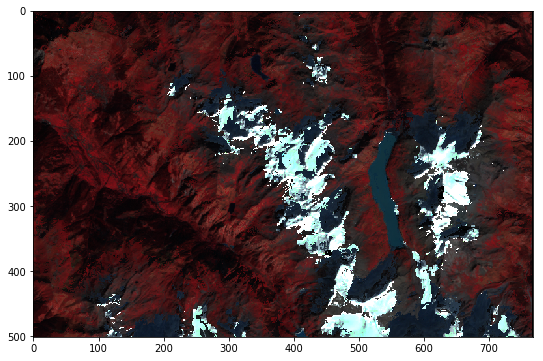

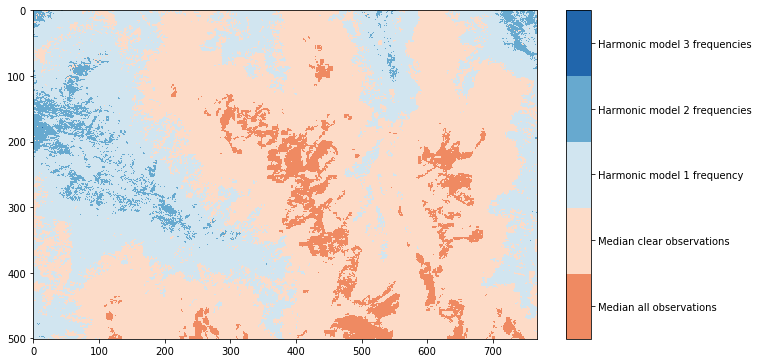

In [4]:
image_rescaled = np.true_divide(image, 10000)

import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
xyz_shape = (image_rescaled.shape[0], image_rescaled.shape[1], 3)
rgb_cube = np.ndarray(xyz_shape)
rgb_cube[:,:,0] = image_rescaled[:,:,3]
rgb_cube[:,:,1] = image_rescaled[:,:,2]
rgb_cube[:,:,2] = image_rescaled[:,:,1]



fig, ax = plt.subplots(figsize=(10,6))   
plt.imshow(rgb_cube)

classes = [
    'Median all observations',
    'Median clear observations',
    'Harmonic model 1 frequency',
    'Harmonic model 2 frequencies',
    'Harmonic model 3 frequencies'
]


hex_colors = [
    '#ef8a62',
    "#fddbc7",
    "#d1e5f0",
    "#67a9cf",
    "#2166ac"
]

cmap = mpl.colors.ListedColormap(hex_colors)
norm = mpl.colors.BoundaryNorm(np.arange(-0.5,5), cmap.N)
        
fig, ax = plt.subplots(figsize=(10,10))        
im = ax.imshow(model[:,:,0], cmap=cmap, norm=norm)

divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size="5%", pad=0.4, pack_start=False)
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation="vertical", ticks=np.linspace(0,4,5))
cbar.ax.set_yticklabels(classes)

In [237]:
# compare observations to predicted surface reflectance values
# save data as csv


""" //////////////////////// main //////////////////////// """

# these parameters can be changed

# run for different region of interests 
roi = 'roi2'

# year of data acquisition
year = 2006 if roi=='roi2' else 2007


# path to data
path_obs = f'D:/thesis/scripts/data/validation/quantitative_validation/synthetic_image_components/{roi}/'
path_pred = f'D:/thesis/scripts/data/validation/quantitative_validation/synthetic_images/{roi}/'


df_doys = pd.read_csv(f'{path_obs}validation_DOYs.csv')
doys = list(df_doys['DOY'])


observed_list = []
predicted_list = []
band_list = []
doy_list = []

for iband, band in enumerate(spectral_bands):

    # read in the validation data for the spectral band
    fname_obs = f'{path_obs}validation_{roi}_{year}_{band}.tif'
    ds_obs = gdal.Open(fname_obs)
    observed, _, _ = geotiff_to_datacube(ds_obs)
    
    for idoy, doy in enumerate(doys):
        
        # read in the synthetic image (predicted data)
        fname_pred = f'{path_pred}synthetic_image_{roi}_{year}_{doy}.tif'
        ds_pred = gdal.Open(fname_pred)
        predicted, _, _ = geotiff_to_datacube(ds_pred)
        
        name = f'{band}_{doy}'
        data_list = []
        
        # loop over all pixels
        for index, _ in np.ndenumerate(observed[:,:,0]):
            irow = index[0]
            icol = index[1]
            
            if observed[irow,icol,idoy] != 0:
                
                observed_value = 10000 if observed[irow,icol,idoy]>10000 else observed[irow,icol,idoy]
                observed_list.append(observed_value)
                predicted_list.append(predicted[irow,icol,iband])
                band_list.append(band)
                doy_list.append(doy)

df_output = pd.DataFrame({
    'observed': observed_list,
    'predicted': predicted_list,
    'band': band_list,
    'DOY': doy_list
})

path_output = f'D:/thesis/scripts/data/validation/quantitative_validation/values/'
df_output.to_csv(f'{path_output}data_model_evaluation_{roi}_{year}.csv', encoding='utf-8', index=False)


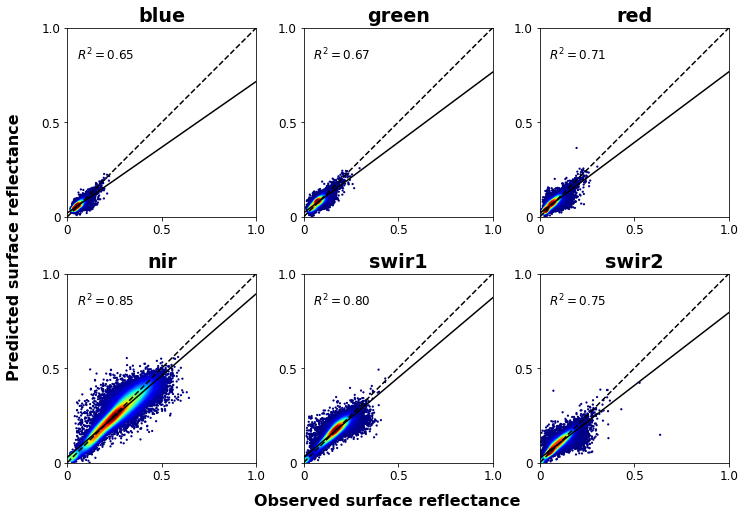

In [7]:
# importing modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd
from scipy import stats
import os

%matplotlib inline



# function to get labels for a list of ticks
def get_labels(ticks):
    ticks = [str(t) for t in ticks]
    max_length = max([len(tick) for tick in ticks])
    labels = [tick + ('0'*(max_length-len(tick))) for tick in ticks]
    labels[0] = '0'
    return labels

# function to plot predicted (y) against reference (x) values
# additionally linear regression and 1 to 1 line are added
def scatterplot(ax,x,y,name='',fontsize=12):
    
    # convert to numpy arrays
    x = np.array(x)/10000; y = np.array(y)/10000
    
    value_limit = 1
    
    # compute r-squared
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    r_square = r_value**2
    
    # compute linear regression
    fit = np.polyfit(x,y,1)
    fit_fn = np.poly1d(fit)
    
    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    
    # colormap
    cm = plt.cm.get_cmap('jet')

    # x and y limits
    x_lin = [0,value_limit]; y_lin = [0,value_limit]
    
    ax.scatter(x, y, c=z, s=5, edgecolor='', cmap=cm)
    ax.plot(x_lin, y_lin, color='black', linestyle='--')
    ax.plot(x_lin, fit_fn(x_lin), color='black')
    ax.set_aspect('equal','box')
    
    # box with r square
    textstr = r'$R^2=%.2f$' % (r_square, )
    props = dict(boxstyle='square', facecolor='white', alpha=0.5, edgecolor='white')
    ax.text(0.05, 0.90, textstr, transform=ax.transAxes, fontsize=fontsize,
        verticalalignment='top', bbox=props)

    # titles
    ax.set_title(name,fontweight='bold')

    value_min = 0
    step_ticks = (value_limit-value_min)/2
    # axes limits
    ax.set_xlim([value_min, value_limit])
    ax.set_ylim([value_min, value_limit])
    
    x_ticks = np.arange(value_min, value_limit+0.1, step_ticks)
    x_labels = get_labels(x_ticks)
    y_ticks = np.arange(value_min, value_limit+0.1, step_ticks)
    y_labels = get_labels(y_ticks)
    
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels,fontdict={'fontsize': fontsize})
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels,fontdict={'fontsize': fontsize})

    
    return





    

    
################################ main ################################

spectral_bands = ['blue','green','red','nir','swir1','swir2']

# run for different region of interests 
roi = 'roi1'
# year of data acquisition
year = 2006 if roi=='roi2' else 2007


# path to data
path_values = f'D:/thesis/scripts/data/validation/quantitative_validation/values/'
df = pd.read_csv(f'{path_values}data_model_evaluation_{roi}_{year}.csv')



fontsize = 16

fig, axs = plt.subplots(2,3, figsize=(12,8), facecolor='w', edgecolor='k') #sharey=True
plt.rcParams.update({'font.size': fontsize})
fig.subplots_adjust(hspace=0.3, wspace=0.2)
axs = axs.ravel()

# main loop
for i, band in enumerate(spectral_bands):

    ax = axs[i]
    
    # create scatterplot
    df_band = df[df['band']==band]
    x = list(df_band['observed'])
    y = list(df_band['predicted'])
    scatterplot(ax,x,y,band)
    # end of for loop

    
fig.text(0.5, 0.05, 'Observed surface reflectance', ha='center',fontweight='bold',fontsize=fontsize)
fig.text(0.06, 0.5, 'Predicted surface reflectance', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize)

plt.savefig(f'model_evaluation_scatterplots_{roi}_{year}.png', dpi=300, bbox_inches = "tight")
plt.show()



In [7]:
# importing modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd
from scipy import stats
import os

%matplotlib inline


# function to get the root mean square error
def compute_rmse(x,y):
    # convert to numpy arrays
    x = np.array(x)/10000; y = np.array(y)/10000
    return np.sqrt(np.mean((y-x)**2))


################################ main ################################

spectral_bands = ['blue','green','red','nir','swir1','swir2']

# path to data
path_values = f'D:/thesis/scripts/data/validation/quantitative_validation/values/'
df = pd.read_csv(f'{path_values}data_model_evaluation_{roi}_{year}.csv')
doys = sorted(list(df['DOY'].unique()))


fontsize = 16

fig, axs = plt.subplots(3,2, figsize=(12,8), facecolor='w', edgecolor='k') #sharey=True
plt.rcParams.update({'font.size': fontsize})
fig.subplots_adjust(hspace=0.6, wspace=0.2)
axs = axs.ravel()


for iband, band in enumerate(spectral_bands):
    
    ax = axs[iband]
    rmses = []
    
    for idoy, doy in enumerate(doys):
        df_sub = df[(df['band']==band) & (df['DOY']==doy)]
        obs = list(df_sub['observed'])
        pred = list(df_sub['predicted'])
        
        rmses.append(compute_rmse(obs,pred))
    
    
    x_ticks = np.arange(1, 366, 52)
    y_ticks = np.arange(0, 0.2+0.01, 0.1)
    # y_labels = get_labels(y_ticks)
    
    ax.set_xlim([1,365])
    ax.set_ylim([0,0.2])
    
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_ticks,fontdict={'fontsize': 12})
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_ticks,fontdict={'fontsize': 12})
    
    #plt.gca().yaxis.grid(True)
    ax.scatter(doys, rmses, marker='.', color='black')
    ax.set_title(band,fontweight='bold')
    
fig.text(0.5, 0.05, 'DOY', ha='center',fontweight='bold',fontsize=fontsize)
fig.text(0.06, 0.5, 'RMSE', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize)

plt.savefig(f'model_evaluation_rmse_{roi}_{year}.png', dpi=300, bbox_inches = "tight")
plt.show()


NameError: name 'roi' is not defined

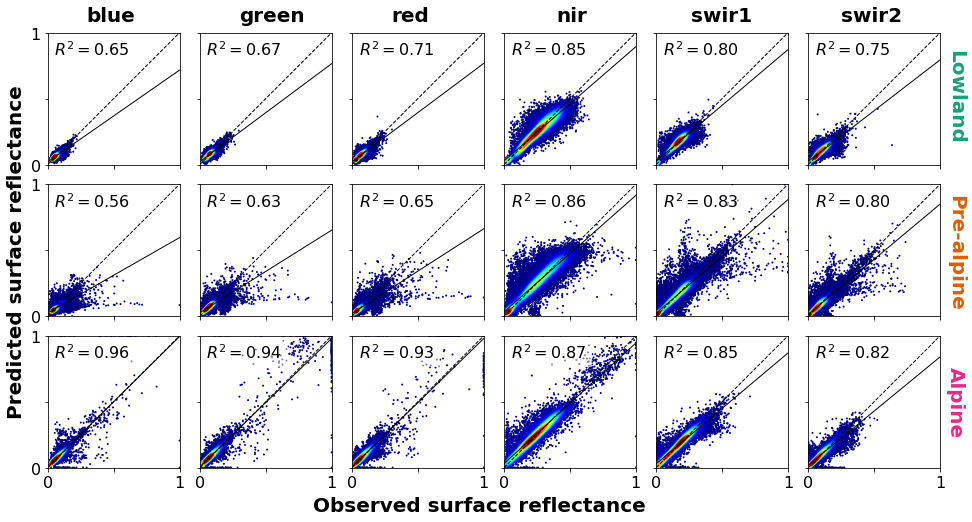

[('roi1', 'blue', 33539), ('roi1', 'green', 33538), ('roi1', 'red', 33539), ('roi1', 'nir', 33537), ('roi1', 'swir1', 33538), ('roi1', 'swir2', 33090), ('roi2', 'blue', 50360), ('roi2', 'green', 50356), ('roi2', 'red', 50358), ('roi2', 'nir', 50361), ('roi2', 'swir1', 50269), ('roi2', 'swir2', 47898), ('roi3', 'blue', 12493), ('roi3', 'green', 12493), ('roi3', 'red', 12493), ('roi3', 'nir', 12493), ('roi3', 'swir1', 12492), ('roi3', 'swir2', 12106)]


In [2]:
# importing modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd
from scipy import stats
import os

%matplotlib inline



# function to get labels for a list of ticks
def get_labels(ticks):
    ticks = [str(t) for t in ticks]
    max_length = max([len(tick) for tick in ticks])
    labels = [tick + ('0'*(max_length-len(tick))) for tick in ticks]
    labels[0] = '0'
    labels[1] = ''
    labels[-1] = '1'
    return labels

# function to plot predicted (y) against reference (x) values
# additionally linear regression and 1 to 1 line are added
def scatterplot(ax,x,y,name='',fontsize=16):
    
    
    # convert to numpy arrays
    x = np.array(x)/10000; y = np.array(y)/10000
    
    value_limit = 1
    
    # compute r-squared
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    r_square = r_value**2
    
    # compute linear regression
    fit = np.polyfit(x,y,1)
    fit_fn = np.poly1d(fit)
    
    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    
    # colormap
    cm = plt.cm.get_cmap('jet')

    # x and y limits
    x_lin = [0,value_limit]; y_lin = [0,value_limit]
    
    ax.scatter(x, y, c=z, s=4, edgecolor='', cmap=cm)
    
    lw=1
    ax.plot(x_lin, y_lin, color='black', linestyle='--',linewidth=lw)
    ax.plot(x_lin, fit_fn(x_lin), color='black',linewidth=lw)
    ax.set_aspect('equal','box')
    
    # box with r square
    textstr = r'$R^2=%.2f$' % (r_square, )
    props = dict(boxstyle='square', facecolor='white', alpha=0.5, edgecolor='white')
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=fontsize,
        verticalalignment='top', bbox=props)

    # titles
    # ax.set_title(name,fontweight='bold')

    value_min = 0
    step_ticks = (value_limit-value_min)/2
    # axes limits
    ax.set_xlim([value_min, value_limit])
    ax.set_ylim([value_min, value_limit])
    
    x_ticks = np.arange(value_min, value_limit+0.1, step_ticks)
    x_labels = get_labels(x_ticks)
    y_ticks = np.arange(value_min, value_limit+0.1, step_ticks)
    y_labels = get_labels(y_ticks)
    
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels,fontdict={'fontsize': fontsize})
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels,fontdict={'fontsize': fontsize})

    
    return





    

    
################################ main ################################

spectral_bands = ['blue','green','red','nir','swir1','swir2']

# run for different region of interests 
rois = ['roi1','roi2','roi3']
years = [2007,2006,2007]

# path to data
path_values = f'D:/thesis/scripts/data/validation/quantitative_validation/values/'
data = {}
for iroi, roi in enumerate(rois):
    df = pd.read_csv(f'{path_values}data_model_evaluation_{roi}_{years[iroi]}.csv')
    data[roi] = df
fontsize_title = 20
fontsize = 16

fig, axs = plt.subplots(3,6, figsize=(16,8), facecolor='w', edgecolor='k', sharex=True, sharey=True) #sharey=True
plt.rcParams.update({'font.size': fontsize})
fig.subplots_adjust(hspace=0.15, wspace=0.15)
axs = axs.ravel()

data_count = []
# main loop
for iroi, roi in enumerate(rois):
    for iband, band in enumerate(spectral_bands):
        ax = axs[iroi*len(spectral_bands)+iband]
    
        # create scatterplot
        df = data[roi]
        df_band = df[df['band']==band]
        data_count.append((roi,band,df_band.shape[0]))
        x = list(df_band['observed'])
        y = list(df_band['predicted'])
        scatterplot(ax,x,y,band)
        # end of for loop

fig.text(0.18, 0.9, spectral_bands[0], ha='center',fontweight='bold',fontsize=fontsize_title)
fig.text(0.32, 0.9, spectral_bands[1], ha='center',fontweight='bold',fontsize=fontsize_title)
fig.text(0.44, 0.9, spectral_bands[2], ha='center',fontweight='bold',fontsize=fontsize_title)
fig.text(0.58, 0.9, spectral_bands[3], ha='center',fontweight='bold',fontsize=fontsize_title)
fig.text(0.71, 0.9, spectral_bands[4], ha='center',fontweight='bold',fontsize=fontsize_title)
fig.text(0.84, 0.9, spectral_bands[5], ha='center',fontweight='bold',fontsize=fontsize_title)
        

fig.text(0.905, 0.77, 'Lowland', va='center', rotation=270, fontweight='bold', fontsize=fontsize_title,color='#1b9e77')
fig.text(0.905, 0.5, 'Pre-alpine', va='center', rotation=270, fontweight='bold',fontsize=fontsize_title,color='#d95f02')
fig.text(0.905, 0.24, 'Alpine', va='center', rotation=270, fontweight='bold',fontsize=fontsize_title,color='#e7298a')    

fig.text(0.5, 0.05, 'Observed surface reflectance', ha='center',fontweight='bold',fontsize=fontsize_title)
fig.text(0.09, 0.5, 'Predicted surface reflectance', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize_title)

plt.savefig(f'model_evaluation_scatterplots.png', dpi=300, bbox_inches = "tight")
plt.show()

print(data_count)


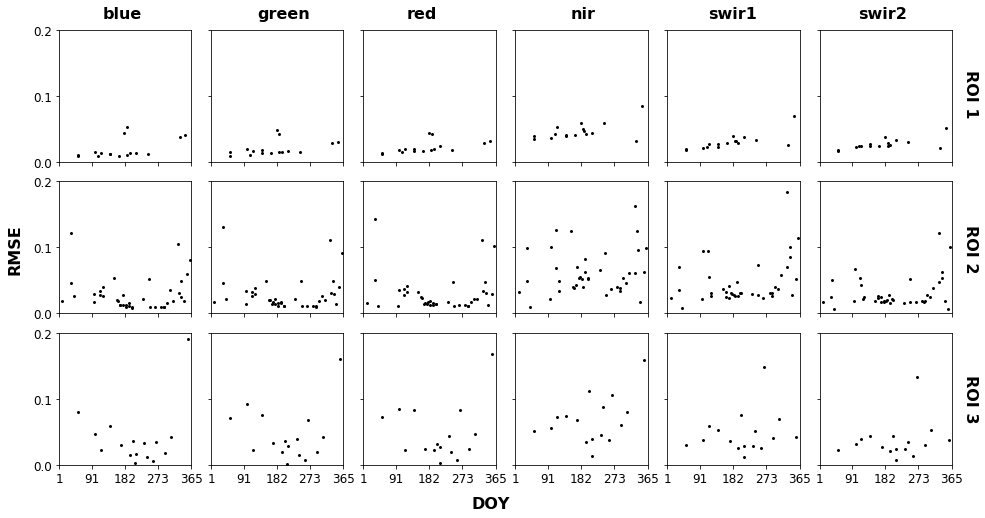

[('roi1', 'blue', 16), ('roi1', 'green', 16), ('roi1', 'red', 16), ('roi1', 'nir', 16), ('roi1', 'swir1', 16), ('roi1', 'swir2', 16), ('roi2', 'blue', 40), ('roi2', 'green', 40), ('roi2', 'red', 40), ('roi2', 'nir', 40), ('roi2', 'swir1', 40), ('roi2', 'swir2', 40), ('roi3', 'blue', 16), ('roi3', 'green', 16), ('roi3', 'red', 16), ('roi3', 'nir', 16), ('roi3', 'swir1', 16), ('roi3', 'swir2', 16)]


In [2]:
# importing modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd
from scipy import stats
import os

%matplotlib inline


# function to get the root mean square error
def compute_rmse(x,y):
    # convert to numpy arrays
    x = np.array(x)/10000; y = np.array(y)/10000
    return np.sqrt(np.mean((y-x)**2))


################################ main ################################

spectral_bands = ['blue','green','red','nir','swir1','swir2']

# run for different region of interests 
rois = ['roi1','roi2','roi3']
years = [2007,2006,2007]

# path to data
path_values = f'D:/thesis/scripts/data/validation/quantitative_validation/values/'
data = {}
for iroi, roi in enumerate(rois):
    df = pd.read_csv(f'{path_values}data_model_evaluation_{roi}_{years[iroi]}.csv')
    data[roi] = df

fontsize = 16

fig, axs = plt.subplots(3,6, figsize=(16,8), facecolor='w', edgecolor='k', sharex=True, sharey=True) #sharey=True
plt.rcParams.update({'font.size': fontsize})
fig.subplots_adjust(hspace=0.15, wspace=0.15)
axs = axs.ravel()


data_count = []
# main loop

for iroi, roi in enumerate(rois):
    
    df = data[roi]
    doys = sorted(list(df['DOY'].unique()))
    
    for iband, band in enumerate(spectral_bands):
        ax = axs[iroi*len(spectral_bands)+iband]
        rmses = []
    
        df_band = df[df['band']==band]
        
        for idoy, doy in enumerate(doys):
            df_doy = df_band[df_band['DOY']==doy]
        
            x = list(df_doy['observed'])
            y = list(df_doy['predicted'])
            rmses.append(compute_rmse(x,y))
            
            
        x_ticks = [ 1,  91, 182, 273, 365]
        y_ticks = np.arange(0, 0.2+0.01, 0.1)
    
        ax.set_xlim([1,365])
        ax.set_ylim([0,0.2])
    
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_ticks,fontdict={'fontsize': 12})
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(y_ticks,fontdict={'fontsize': 12})
    
        ax.scatter(doys, rmses, marker='.', color='black', linewidths=0)
        
        data_count.append((roi,band,len(rmses)))
        # end of for loop

fig.text(0.18, 0.9, spectral_bands[0], ha='center',fontweight='bold',fontsize=fontsize)
fig.text(0.32, 0.9, spectral_bands[1], ha='center',fontweight='bold',fontsize=fontsize)
fig.text(0.44, 0.9, spectral_bands[2], ha='center',fontweight='bold',fontsize=fontsize)
fig.text(0.58, 0.9, spectral_bands[3], ha='center',fontweight='bold',fontsize=fontsize)
fig.text(0.71, 0.9, spectral_bands[4], ha='center',fontweight='bold',fontsize=fontsize)
fig.text(0.84, 0.9, spectral_bands[5], ha='center',fontweight='bold',fontsize=fontsize)
        

fig.text(0.91, 0.77, 'ROI 1', va='center', rotation=270, fontweight='bold', fontsize=fontsize)
fig.text(0.91, 0.5, 'ROI 2', va='center', rotation=270, fontweight='bold',fontsize=fontsize)
fig.text(0.91, 0.24, 'ROI 3', va='center', rotation=270, fontweight='bold',fontsize=fontsize)    


    
fig.text(0.5, 0.05, 'DOY', ha='center',fontweight='bold',fontsize=fontsize)
fig.text(0.08, 0.5, 'RMSE', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize)

plt.savefig(f'model_evaluation_rmse.png', dpi=300, bbox_inches = "tight")
plt.show()

print(data_count)

['02 May', '20 Jul', '22 Sep']


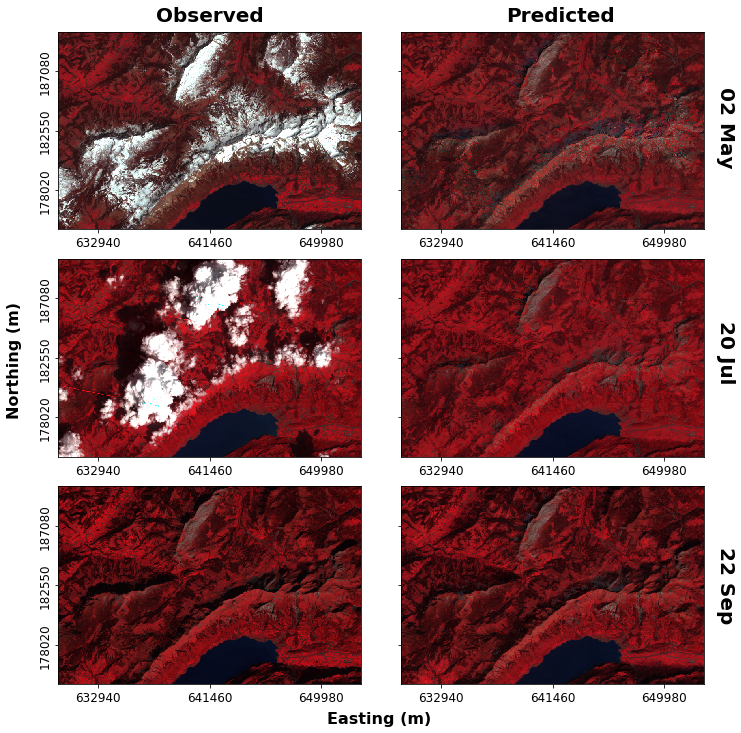

In [52]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import math
import numpy as np

%matplotlib inline

def stretch(ar,limits):
    lower_lim, upper_lim = limits
    clipped_ar = np.clip(ar,lower_lim,upper_lim)
    stretched_ar = (clipped_ar-lower_lim)/(upper_lim-lower_lim)
    return stretched_ar

def plot_geotiff(ax,ds,showy_coords=True):
    
    # read image to numpy array and rescale it to 0 to 1
    image, geotransform, epsg = geotiff_to_datacube(ds)
    image_rescaled = np.true_divide(image, 10000)
    
    # turn image into an rgb data cube
    xyz_shape = (image_rescaled.shape[0], image_rescaled.shape[1], 3)
    rgb_cube = np.ndarray(xyz_shape)
    rgb_cube[:,:,0] = stretch(image_rescaled[:,:,3],(0,0.75))
    rgb_cube[:,:,1] = stretch(image_rescaled[:,:,2],(0,0.75))
    rgb_cube[:,:,2] = stretch(image_rescaled[:,:,1],(0,0.75))
    # plot image
    ax.imshow(rgb_cube,interpolation='none')
    
    # label axes according to geotransform
    x_start, x_res, _, y_start, _, y_res = geotransform
    
    # x axis
    x_offset = 100
    x_ticks = [0+x_offset,xyz_shape[1]//2,xyz_shape[1]-x_offset]
    x_labels = [int(x_start+x_res*i) for i in x_ticks]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels,fontdict={'fontsize': 12})
    
    # y axis
    y_offset = 100
    y_ticks = [0+x_offset,xyz_shape[0]//2,xyz_shape[0]-x_offset]
    y_labels = [int(y_start+y_res*i) for i in y_ticks]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels, rotation='vertical', va="center", position=(0,-0.28), fontdict={'fontsize': 12})
    
    # end of function
    
    
""" //////////////////////// main //////////////////////// """


# run for different region of interests 
roi = 'roi2'
validation_type = 'qualitative'

# year of data acquisition
year = 2006 if roi=='roi2' else 2007


# path to data
path_obs = f'D:/thesis/scripts/data/validation/{validation_type}_validation/synthetic_image_components/{roi}/'
path_pred = f'D:/thesis/scripts/data/validation/{validation_type}_validation/synthetic_images/{roi}/'

# getting acquisition date of validation scenes
df_doys = pd.read_csv(f'{path_obs}validation_DOYs.csv')
doys_validation = sorted(list(set(list(df_doys['DOY']))))
datetime_objects = [datetime.strptime(f'{doy} {year}', '%j %Y') for doy in doys_validation]
date_strings = [datetime_object.strftime('%d %b') for datetime_object in datetime_objects]
print(date_strings)

fontsize = 16
fontsize_title = 20

# fig, axs = plt.subplots(3,2, figsize=(12,12), facecolor='w', edgecolor='k') #sharey=True
fig, axs = plt.subplots(3,2, figsize=(12,12), facecolor='w', edgecolor='k') 
plt.rcParams.update({'font.size': fontsize})
fig.subplots_adjust(hspace=0.15, wspace=0.05)
axs = axs.ravel()

ds = gdal.Open(f'{path_obs}validation_spring_{roi}_{year}.tif')
plot_geotiff(axs[0],ds)

ds = gdal.Open(f'{path_obs}validation_summer_{roi}_{year}.tif')
plot_geotiff(axs[2],ds)

ds = gdal.Open(f'{path_obs}validation_autumn_{roi}_{year}.tif')
plot_geotiff(axs[4],ds)

ds = gdal.Open(f'{path_pred}synthetic_image_{roi}_{year}_{doys_validation[0]}.tif')
plot_geotiff(axs[1],ds)

ds = gdal.Open(f'{path_pred}synthetic_image_{roi}_{year}_{doys_validation[1]}.tif')
plot_geotiff(axs[3],ds)

ds = gdal.Open(f'{path_pred}synthetic_image_{roi}_{year}_{doys_validation[2]}.tif')
plot_geotiff(axs[5],ds)

fig.text(0.51, 0.08, 'Easting (m)', ha='center',fontweight='bold',fontsize=fontsize)
fig.text(0.08, 0.5, 'Northing (m)', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize)

fig.text(0.315, 0.892, 'Observed', ha='center',fontweight='bold',fontsize=fontsize_title)
fig.text(0.72, 0.892, 'Predicted', ha='center',fontweight='bold',fontsize=fontsize_title)

fig.text(0.9, 0.77, date_strings[0], va='center', rotation=270,fontweight='bold',fontsize=fontsize_title)
fig.text(0.9, 0.51, date_strings[1], va='center', rotation=270,fontweight='bold',fontsize=fontsize_title)
fig.text(0.9, 0.24, date_strings[2], va='center', rotation=270,fontweight='bold',fontsize=fontsize_title)

plt.savefig(f'qualitative_validation_{roi}_{year}.png', dpi=300, bbox_inches = "tight")



['10 Apr', '23 Jul', '19 Oct']


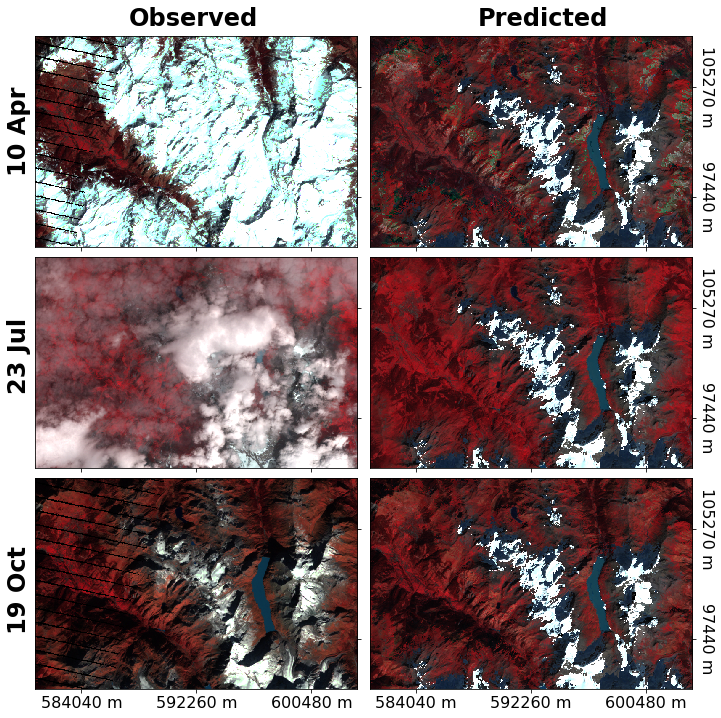

In [88]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import math
import numpy as np

%matplotlib inline

def stretch(ar,limits):
    lower_lim, upper_lim = limits
    clipped_ar = np.clip(ar,lower_lim,upper_lim)
    stretched_ar = (clipped_ar-lower_lim)/(upper_lim-lower_lim)
    return stretched_ar

def plot_geotiff(ax,ds,show_ylabels=True):
    
    # read image to numpy array and rescale it to 0 to 1
    image, geotransform, epsg = geotiff_to_datacube(ds)
    image_rescaled = np.true_divide(image, 10000)
    
    # turn image into an rgb data cube
    xyz_shape = (image_rescaled.shape[0], image_rescaled.shape[1], 3)
    rgb_cube = np.ndarray(xyz_shape)
    rgb_cube[:,:,0] = stretch(image_rescaled[:,:,3],(0,0.75))
    rgb_cube[:,:,1] = stretch(image_rescaled[:,:,2],(0,0.75))
    rgb_cube[:,:,2] = stretch(image_rescaled[:,:,1],(0,0.75))
    # plot image
    ax.imshow(rgb_cube,interpolation='none')
    
    # label axes according to geotransform
    x_start, x_res, _, y_start, _, y_res = geotransform
    
    # x axis
    x_offset = 110
    x_ticks = [0+x_offset,xyz_shape[1]//2,xyz_shape[1]-x_offset]
    x_labels = [f'{x_start+x_res*i:.0f} m' for i in x_ticks]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels,fontdict={'fontsize': fontsize})
    
    # y axis
    y_offset = 120
    y_ticks = [0+y_offset,xyz_shape[0]-y_offset]
    y_labels = [f'{y_start+y_res*i:.0f} m' for i in y_ticks] if show_ylabels==True else []
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels, rotation=270, va="center", fontdict={'fontsize': fontsize})
    
    
    # end of function
    
    
""" //////////////////////// main //////////////////////// """


# run for different region of interests 
roi = 'roi3'
validation_type = 'qualitative'

# year of data acquisition
year = 2006 if roi=='roi2' else 2007


# path to data
path_obs = f'D:/thesis/scripts/data/validation/{validation_type}_validation/synthetic_image_components/{roi}/'
path_pred = f'D:/thesis/scripts/data/validation/{validation_type}_validation/synthetic_images/{roi}/'

# getting acquisition date of validation scenes
df_doys = pd.read_csv(f'{path_obs}validation_DOYs.csv')
doys_validation = sorted(list(set(list(df_doys['DOY']))))
datetime_objects = [datetime.strptime(f'{doy} {year}', '%j %Y') for doy in doys_validation]
date_strings = [datetime_object.strftime('%d %b') for datetime_object in datetime_objects]
print(date_strings)

fontsize = 16
fontsize_title = 24

# fig, axs = plt.subplots(3,2, figsize=(10,10), facecolor='w', edgecolor='k') #sharey=True
fig, axs = plt.subplots(3,2, figsize=(12,12), facecolor='w', edgecolor='k', sharex=True) #sharey=True
plt.rcParams.update({'font.size': fontsize})
fig.subplots_adjust(hspace=0.05, wspace=0)
axs = axs.ravel()

ds = gdal.Open(f'{path_obs}validation_spring_{roi}_{year}.tif')
plot_geotiff(axs[0],ds,False)

ds = gdal.Open(f'{path_obs}validation_summer_{roi}_{year}.tif')
plot_geotiff(axs[2],ds,False)

ds = gdal.Open(f'{path_obs}validation_autumn_{roi}_{year}.tif')
plot_geotiff(axs[4],ds,False)

ds = gdal.Open(f'{path_pred}synthetic_image_{roi}_{year}_{doys_validation[0]}.tif')
plot_geotiff(axs[1],ds)

ds = gdal.Open(f'{path_pred}synthetic_image_{roi}_{year}_{doys_validation[1]}.tif')
plot_geotiff(axs[3],ds)

ds = gdal.Open(f'{path_pred}synthetic_image_{roi}_{year}_{doys_validation[2]}.tif')
plot_geotiff(axs[5],ds)


fig.text(0.315, 0.892, 'Observed', ha='center',fontweight='bold',fontsize=fontsize_title)
fig.text(0.72, 0.892, 'Predicted', ha='center',fontweight='bold',fontsize=fontsize_title)

fig.text(0.1, 0.77, date_strings[0], va='center', rotation='vertical',fontweight='bold',fontsize=fontsize_title)
fig.text(0.1, 0.51, date_strings[1], va='center', rotation='vertical',fontweight='bold',fontsize=fontsize_title)
fig.text(0.1, 0.24, date_strings[2], va='center', rotation='vertical',fontweight='bold',fontsize=fontsize_title)

plt.savefig(f'qualitative_validation_{roi}_{year}.png', dpi=300, bbox_inches = "tight")


['10 Apr', '07 Jul', '28 Oct']


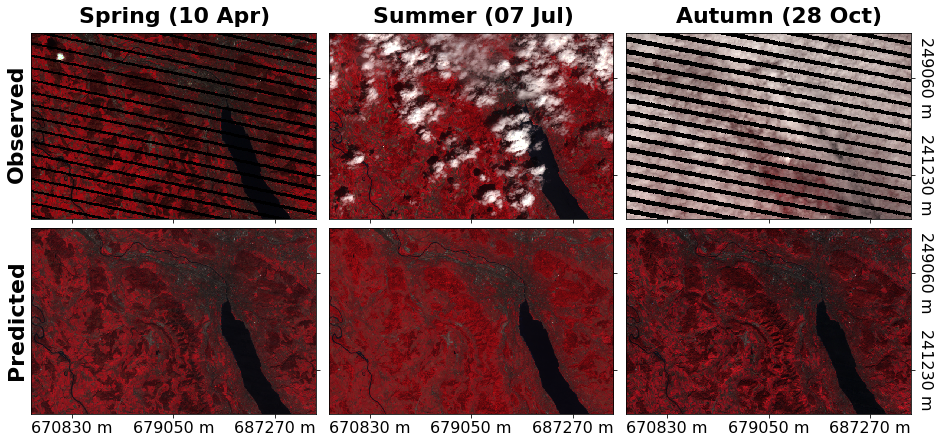

In [30]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import math
import numpy as np

%matplotlib inline

def stretch(ar,limits):
    lower_lim, upper_lim = limits
    clipped_ar = np.clip(ar,lower_lim,upper_lim)
    stretched_ar = (clipped_ar-lower_lim)/(upper_lim-lower_lim)
    return stretched_ar

def plot_geotiff(ax,ds,show_ylabels=True):
    
    # read image to numpy array and rescale it to 0 to 1
    image, geotransform, epsg = geotiff_to_datacube(ds)
    image_rescaled = np.true_divide(image, 10000)
    
    # turn image into an rgb data cube
    xyz_shape = (image_rescaled.shape[0], image_rescaled.shape[1], 3)
    rgb_cube = np.ndarray(xyz_shape)
    rgb_cube[:,:,0] = stretch(image_rescaled[:,:,3],(0,0.75))
    rgb_cube[:,:,1] = stretch(image_rescaled[:,:,2],(0,0.75))
    rgb_cube[:,:,2] = stretch(image_rescaled[:,:,1],(0,0.75))
    # plot image
    ax.imshow(rgb_cube,interpolation='none')
    
    # label axes according to geotransform
    x_start, x_res, _, y_start, _, y_res = geotransform
    
    # x axis
    x_offset = 110
    x_ticks = [0+x_offset,xyz_shape[1]//2,xyz_shape[1]-x_offset]
    x_labels = [f'{x_start+x_res*i:.0f} m' for i in x_ticks]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels,fontdict={'fontsize': fontsize})
    
    # y axis
    y_offset = 120
    y_ticks = [0+y_offset,xyz_shape[0]-y_offset]
    y_labels = [f'{y_start+y_res*i:.0f} m' for i in y_ticks] if show_ylabels==True else []
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels, rotation=270, va="center", fontdict={'fontsize': fontsize})
    
    
    # end of function
    
    
""" //////////////////////// main //////////////////////// """


# run for different region of interests 
roi = 'roi1'
validation_type = 'qualitative'

# year of data acquisition
year = 2006 if roi=='roi2' else 2007


# path to data
path_obs = f'D:/thesis/scripts/data/validation/{validation_type}_validation/synthetic_image_components/{roi}/'
path_pred = f'D:/thesis/scripts/data/validation/{validation_type}_validation/synthetic_images/{roi}/'

# getting acquisition date of validation scenes
df_doys = pd.read_csv(f'{path_obs}validation_DOYs.csv')
doys_validation = sorted(list(set(list(df_doys['DOY']))))
datetime_objects = [datetime.strptime(f'{doy} {year}', '%j %Y') for doy in doys_validation]
date_strings = [datetime_object.strftime('%d %b') for datetime_object in datetime_objects]
print(date_strings)

fontsize = 16
fontsize_title = 22

# fig, axs = plt.subplots(3,2, figsize=(10,10), facecolor='w', edgecolor='k') #sharey=True
fig, axs = plt.subplots(2,3, figsize=(16,7), facecolor='w', edgecolor='k', sharex=True) #sharey=True
plt.rcParams.update({'font.size': fontsize})
fig.subplots_adjust(hspace=0.05, wspace=0)
axs = axs.ravel()

ds = gdal.Open(f'{path_obs}validation_spring_{roi}_{year}.tif')
plot_geotiff(axs[0],ds,False)

ds = gdal.Open(f'{path_obs}validation_summer_{roi}_{year}.tif')
plot_geotiff(axs[1],ds,False)

ds = gdal.Open(f'{path_obs}validation_autumn_{roi}_{year}.tif')
plot_geotiff(axs[2],ds)

ds = gdal.Open(f'{path_pred}synthetic_image_{roi}_{year}_{doys_validation[0]}.tif')
plot_geotiff(axs[3],ds,False)

ds = gdal.Open(f'{path_pred}synthetic_image_{roi}_{year}_{doys_validation[1]}.tif')
plot_geotiff(axs[4],ds,False)

ds = gdal.Open(f'{path_pred}synthetic_image_{roi}_{year}_{doys_validation[2]}.tif')
plot_geotiff(axs[5],ds)




fig.text(0.255, 0.9, f'Spring ({date_strings[0]})', ha='center',fontweight='bold',fontsize=fontsize_title)
fig.text(0.515, 0.9, f'Summer ({date_strings[1]})', ha='center',fontweight='bold',fontsize=fontsize_title)
fig.text(0.78, 0.9, f'Autumn ({date_strings[2]})', ha='center',fontweight='bold',fontsize=fontsize_title)

fig.text(0.11, 0.7, 'Observed', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize_title)
fig.text(0.11, 0.31, 'Predicted', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize_title)

plt.savefig(f'qualitative_validation_presentation_{roi}_{year}.png', dpi=300, bbox_inches = "tight")


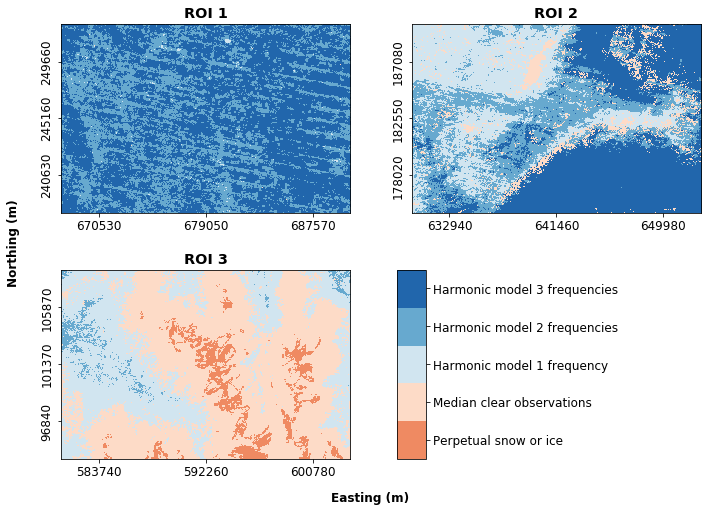

In [6]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_model(ax,ds,colors,title):
    
    
    model, geotransform, epsg = geotiff_to_datacube(ds)
    

    
    cmap = mpl.colors.ListedColormap(colors)
    norm = mpl.colors.BoundaryNorm(np.arange(-0.5,5), cmap.N)
    
    im = ax.imshow(model[:,:,0], cmap=cmap, norm=norm)
    
    
    # label axes according to geotransform
    x_start, x_res, _, y_start, _, y_res = geotransform
    
    # x axis
    x_offset = 100
    x_ticks = [0+x_offset,model.shape[1]//2,model.shape[1]-x_offset]
    x_labels = [int(x_start+x_res*i) for i in x_ticks]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels,fontdict={'fontsize': 12})
    
    # y axis
    y_offset = 100
    y_ticks = [0+x_offset,model.shape[0]//2,model.shape[0]-x_offset]
    y_labels = [int(y_start+y_res*i) for i in y_ticks]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels, rotation='vertical', va="center", position=(0,-0.28), fontdict={'fontsize': 12})
    
    # title
    ax.set_title(title, fontweight='bold')
    
    return im
    # end of function
    

""" //////////////////////// main //////////////////////// """


# run for different region of interests 
rois = ['roi1','roi2','roi3']
years = [2007,2006,2007]
validation_type = 'qualitative'


# path to data
paths = [f'D:/thesis/scripts/data/validation/{validation_type}_validation/synthetic_images/{roi}/' for roi in rois]

fontsize = 12

classes = [
    'Perpetual snow or ice',
    'Median clear observations',
    'Harmonic model 1 frequency',
    'Harmonic model 2 frequencies',
    'Harmonic model 3 frequencies'
]

hex_colors = [
    '#ef8a62',
    "#fddbc7",
    "#d1e5f0",
    "#67a9cf",
    "#2166ac"
]



fig, axs = plt.subplots(2,2, figsize=(12,8), facecolor='w', edgecolor='k') #sharey=True
plt.rcParams.update({'font.size': fontsize})
fig.subplots_adjust(hspace=0.3, wspace=0.1)
axs = axs.ravel()

for i, ax in enumerate(axs[0:3]):
    ds = gdal.Open(f'{paths[i]}model_{rois[i]}_{years[i]}.tif')
    im = plot_model(axs[i],ds,hex_colors,f'ROI {rois[i][-1]}')

divider = make_axes_locatable(axs[3])
cax = divider.new_horizontal(size="5%", pad=4, pack_start=False)
#fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation="vertical", ticks=np.linspace(0,4,5))
cbar.ax.set_yticklabels(classes)

cbar = fig.colorbar(im,cax=axs[3], orientation="vertical", ticks=np.linspace(0,4,5))
cbar.ax.set_yticklabels(classes)

fig.text(0.5, 0.05, 'Easting (m)', ha='center',fontweight='bold',fontsize=fontsize)
fig.text(0.08, 0.5, 'Northing (m)', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize)

plt.savefig(f'models.png', dpi=300, bbox_inches = "tight")

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import datetime as dt
import math
import numpy as np
import osr
from osgeo import gdal
from IPython.display import display, clear_output
%matplotlib inline

# global variables
spectral_bands = ['blue','green','red','nir','swir1','swir2']

# function to get arealstatistik data collection year for campaign and roi
def collection_year(roi,yearAS):
    
    if yearAS == 2004:
        year = 2006 if roi=='roi2' else 2007
    elif yearAS == 2013:
        year = 2015 if roi=='roi2' else 2016
    
    return year
    # end of collection year function


# function to read in a data cube from a geo tiff file
def geotiff2datacube(fname):
    
    ds = gdal.Open(fname)
    
    geotransform = ds.GetGeoTransform()
    
    proj = osr.SpatialReference(wkt=ds.GetProjection())
    epsg = int(proj.GetAttrValue('AUTHORITY',1))
    
    xy_shape = np.array(ds.GetRasterBand(1).ReadAsArray()).shape
    
    # get number of bands in raster file
    n_bands = ds.RasterCount
    
    # initialize a data cube
    xyz_shape = xy_shape + (n_bands,)
    data_cube = np.ndarray(xyz_shape)
    
    # fill it with bands
    for i in range(1,n_bands+1):
        data_cube[:,:,i-1] =  np.array(ds.GetRasterBand(i).ReadAsArray())
    
    return data_cube, geotransform, epsg
    # end of read in datacube function


# function to save a data cube as a geotiff file
def save_geotiff(data_cube, geotransform, epsg, fname):
    
    n_rows, n_cols, n_bands = data_cube.shape
    
    # open geo tiff file
    ds = gdal.GetDriverByName('GTiff').Create('placeholder.tif',n_cols, n_rows, n_bands, gdal.GDT_Float32)
    ds.SetGeoTransform(geotransform)
    
    # set crs
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(epsg)
    ds.SetProjection(srs.ExportToWkt())
    
    # write data cube to geo tiff
    for i_band in range(n_bands):
        ds.GetRasterBand(i_band+1).WriteArray(data_cube[:,:,i_band])
    
    dst_ds = gdal.GetDriverByName('GTiff').CreateCopy(fname+'.tif', ds)
    dst_ds = None
    # end of save geotiff function

    
def convert_date(date):
    ref = dt.datetime(1970,1,1)
    diff = (date-ref).days/365.24
    return diff*2*math.pi
 
    
def coefficients2value(coefficients, doy, year):
   
    n_harmonics = 1
    
    str_year = str(year)
    str_doy = str(doy)
    for _ in range(3-len(str_doy)): str_doy = '0'+str_doy
    
    date = dt.datetime.strptime(f'{str_doy} {str_year}', '%j %Y')
    date = convert_date(date)
    
    # compute independents
    cos_independents = [math.cos(date*freq) for freq in range(1,n_harmonics+1)]
    sin_independents = [math.sin(date*freq) for freq in range(1,n_harmonics+1)]
    
    # add constant
    value = coefficients[0]
    # add harmonics
    for i in range(n_harmonics):
        cos_index = 1+i
        sin_index = 1+n_harmonics+i
        value += cos_independents[i]*coefficients[cos_index]
        value += sin_independents[i]*coefficients[sin_index]
        
    return int(value)
 
def coefficients2image(coefficients_file, doy, year):

    print(f'Generating synthetic image (Year: {year}, DOY: {doy})')
    
    coefficients, geotransform, epsg = geotiff2datacube(coefficients_file)
    # coefficients = coefficients[0:5,0:5]
        
    # initialize image
    shape = list(coefficients.shape)
    shape[2] = len(spectral_bands)
    image = np.zeros(tuple(shape))
    
    # progress report
    n_pixels = shape[0]*shape[1]
    step = n_pixels//10
    
    # loop over all pixels
    for index, _ in np.ndenumerate(image):
        irow, icol, iband = index
        value = coefficients2value(coefficients[irow,icol,iband*3:iband*3+3],doy,year)
        image[irow,icol,iband] = value
        
        # cap
        if value<0: image[irow,icol,iband]=0
        if value>10000: image[irow,icol,iband]=10000
        

        # report progress
        curr_pixel = irow*shape[1]+icol
        if curr_pixel!=0 and curr_pixel%step==0:
            clear_output(wait=True)
            display(f'{int(curr_pixel/n_pixels*100)+1}%')
        
    return image, geotransform, epsg


def valid_coefficients(visual_coefficients, year):
    visual_values = []
    for coefficients in visual_coefficients:
        # const = coefficients[0]
        # a, b = coefficients[1:]
        # amplitude = np.sqrt(np.power(a,2)+np.power(b,2))
        # max_ = const+amplitude
        # min_ = const-amplitude
        # visual_values.extend([max_,min_])
        band_values = [coefficients2value(coefficients,doy,year) for doy in [28,91,182,273,336]]
        visual_values.extend(band_values)
    valid = [False for value in visual_values if value<0 or value>5000]
    return all(valid)
    
    
def assemble_coefficients(path, roi, year):
    
    median, _, _ = geotiff2datacube(f'{path}median_{roi}_{year}.tif')
    perpetual_snow, _, _ = geotiff2datacube(f'{path}perpetual_snow_{roi}_{year}.tif')
    count, geotransform, epsg = geotiff2datacube(f'{path}count_min_{roi}_{year}.tif')
    
    # read in harmonic coefficients, medians and counts for all spectral bands 
    coefs = []
        
    for band in spectral_bands:    
        coef, _, _ = geotiff2datacube(f'{path}coefficients_{roi}_{year}_{band}.tif')
        coefs.append(coef)
    
    
    # initialize model
    xyz_shape = list(count.shape)
    model = np.ndarray(tuple(xyz_shape), dtype=np.uint8)
    
    # initialize coefficients
    xyz_shape[2] = len(spectral_bands)*3
    coefficients = np.zeros(tuple(xyz_shape))
    
    # progress report
    n_pixels = xyz_shape[0]*xyz_shape[1]
    step = n_pixels//20
    
    
    # loop over all pixels
    for index, c in np.ndenumerate(count):
        irow = index[0]
        icol = index[1]
        
        # apply model according to count for each spectral band     
        for iband, band in enumerate(spectral_bands):
            
            if perpetual_snow[irow,icol,0]==1:
                coefficients[irow,icol,iband*3] = median[irow,icol,iband]
                model[irow,icol,0] = 0
            else:
                if c>12:
                    coefficients[irow,icol,iband*3:iband*3+3] = coefs[iband][irow,icol,:]
                    model[irow,icol,0] = 2
                else:
                    coefficients[irow,icol,iband*3] = median[irow,icol,iband]
                    model[irow,icol,0] = 1
            # end of loop over spectral bands
            
        
        # postprocessing
        # for harmonic models, check the coefficient's validity
        if c>12 and perpetual_snow[irow,icol,0]==0:
            
            coefficients_bgr = [coefficients[irow,icol,0:3],coefficients[irow,icol,3:6],coefficients[irow,icol,6:9]]
            valid = valid_coefficients(coefficients_bgr,year)  
            
            if not valid:
                for iband in range(len(spectral_bands)):
                    coefficients[irow,icol,iband*3:iband*3+3] = [0 for i in range(3)] 
                    coefficients[irow,icol,iband*3] = median[irow,icol,iband]
                    model[irow,icol,0] = 1
         
        # for median models, cap values
        if c<12 or perpetual_snow[irow,icol,0]==1:
            for iband in range(len(spectral_bands)):
                if coefficients[irow,icol,iband*3]<0: coefficients[irow,icol,iband*3]=0
                if coefficients[irow,icol,iband*3]>10000: coefficients[irow,icol,iband*3]=10000

        # report progress
        curr_pixel = irow*xyz_shape[1]+icol
        if curr_pixel!=0 and curr_pixel%step==0:
            clear_output(wait=True)
            display(f'{roi.upper()}: {int(curr_pixel/n_pixels*100)+1}%')
        
        # end of loop over pixels
        
    print()
    
    return coefficients, model, geotransform, epsg
    
    # end of generate image at doy function
    
    


In [2]:
""" //////////////////////// qualitative validation //////////////////////// """

# run for different region of interests 
rois = ['roi1','roi2','roi3']
yearAS = 2004

# path to data
folder_components = f'data/validation/qualitative/gee_components/'
folder_coefficients = f'data/validation/qualitative/coefficients/'
folder_images = f'data/validation/qualitative/synthetic_images/'

for roi in rois:
    
    year = collection_year(roi,yearAS)

    # assemble components to coefficients
    coefficients, model, geotransform, epsg = assemble_coefficients(folder_components,roi,year)
    save_geotiff(coefficients, geotransform, epsg, f'{folder_coefficients}coefficients_{roi}_{year}')
    save_geotiff(model, geotransform, epsg, f'{folder_coefficients}model_{roi}_{year}')

    # get doy of the validation images
    df_doys = pd.read_csv(f'{folder_components}validation_DOYs_{roi}_{year}.csv')
    doys_validation = list(set(list(df_doys['DOY'])))
    print(doys_validation)
    
    # generate synthetic images at dates of validation images
    for doy in doys_validation:
        coefficients_file = f'{folder_coefficients}coefficients_{roi}_{year}.tif'
        image, geotransform, epsg = coefficients2image(coefficients_file, doy, year)
        save_geotiff(image, geotransform, epsg, f'{folder_images}synthetic_image_{roi}_{year}_{doy}')


'100%'

['10 Apr', '07 Jul', '28 Oct']


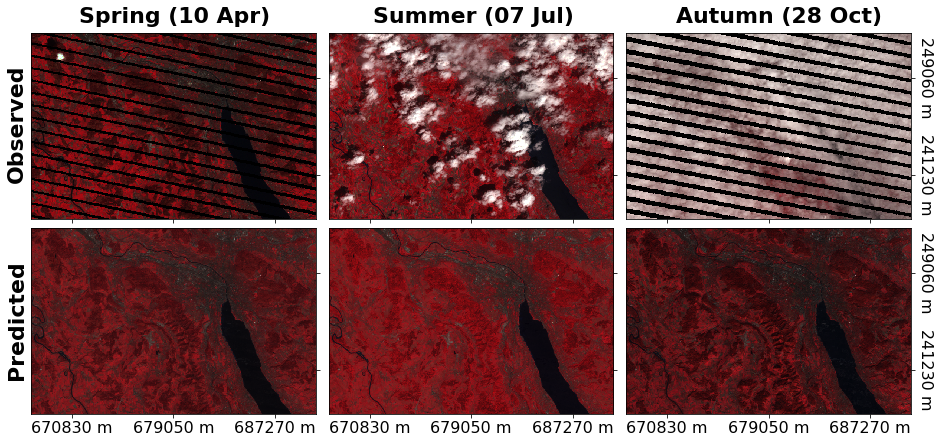

['02 May', '20 Jul', '22 Sep']


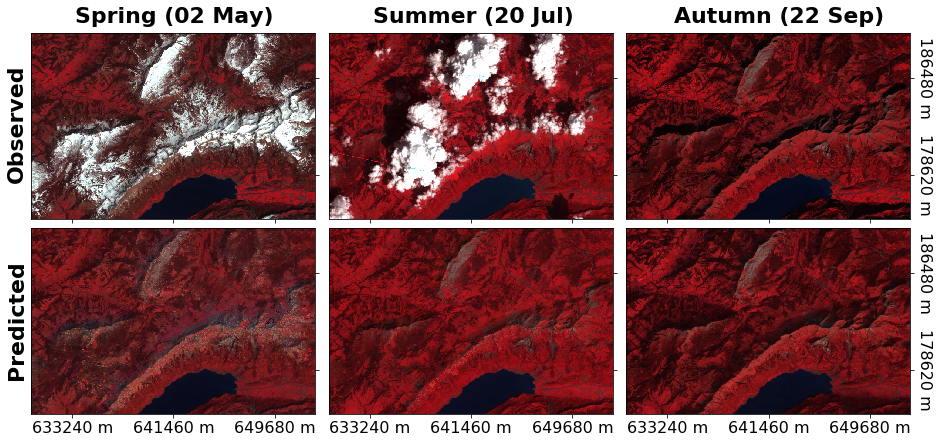

['10 Apr', '23 Jul', '19 Oct']


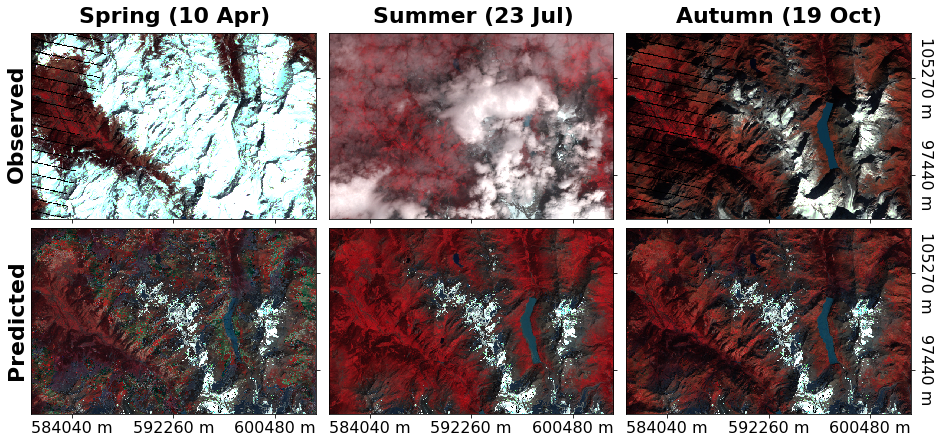

In [3]:
""" //////////////////////// qualitative validation plots //////////////////////// """


def plot_geotiff(ax,fname,show_ylabels=True):
    
    # reading in geotiff and rescale image it  [0 to 1]
    image, geotransform, epsg = geotiff2datacube(fname)
    image_rescaled = np.true_divide(image, 10000)
    
    # function to stretch image for better visualization
    def stretch(ar,limits):
        lower_lim, upper_lim = limits
        clipped_ar = np.clip(ar,lower_lim,upper_lim)
        stretched_ar = (clipped_ar-lower_lim)/(upper_lim-lower_lim)
        return stretched_ar

    # turn image into an rgb data cube
    xyz_shape = (image_rescaled.shape[0], image_rescaled.shape[1], 3)
    rgb_cube = np.ndarray(xyz_shape)
    rgb_cube[:,:,0] = stretch(image_rescaled[:,:,3],(0,0.75))
    rgb_cube[:,:,1] = stretch(image_rescaled[:,:,2],(0,0.75))
    rgb_cube[:,:,2] = stretch(image_rescaled[:,:,1],(0,0.75))
    # plot image
    ax.imshow(rgb_cube,interpolation='none')
    
    # label axes according to geotransform
    x_start, x_res, _, y_start, _, y_res = geotransform
    
    # x axis
    x_offset = 110
    x_ticks = [0+x_offset,xyz_shape[1]//2,xyz_shape[1]-x_offset]
    x_labels = [f'{x_start+x_res*i:.0f} m' for i in x_ticks]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels,fontdict={'fontsize': fontsize})
    
    # y axis
    y_offset = 120
    y_ticks = [0+y_offset,xyz_shape[0]-y_offset]
    y_labels = [f'{y_start+y_res*i:.0f} m' for i in y_ticks] if show_ylabels==True else []
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels, rotation=270, va="center", fontdict={'fontsize': fontsize})
    
    
    # end of function
    
    
""" //////////////////////// main //////////////////////// """

# run for different region of interests 
rois = ['roi1','roi2','roi3']
yearAS = 2004

# path to data
folder_validation = f'data/validation/qualitative/gee_components/'
folder_model = f'data/validation/qualitative/coefficients/'
folder_images = f'data/validation/qualitative/synthetic_images/'


for roi in rois:
    
    year = collection_year(roi,yearAS)
    

    # getting acquisition date of validation scenes
    df_doys = pd.read_csv(f'{folder_validation}validation_DOYs_{roi}_{year}.csv')
    doys_validation = sorted(list(set(list(df_doys['DOY']))))
    datetime_objects = [dt.datetime.strptime(f'{doy} {year}', '%j %Y') for doy in doys_validation]
    date_strings = [datetime_object.strftime('%d %b') for datetime_object in datetime_objects]
    print(date_strings)

    fontsize = 16
    fontsize_title = 22

    fig, axs = plt.subplots(2,3, figsize=(16,7), facecolor='w', edgecolor='k', sharex=True)
    plt.rcParams.update({'font.size': fontsize})
    fig.subplots_adjust(hspace=0.05, wspace=0)
    axs = axs.ravel()

    plot_geotiff(axs[0],f'{folder_validation}validation_spring_{roi}_{year}.tif',False)
    plot_geotiff(axs[1],f'{folder_validation}validation_summer_{roi}_{year}.tif',False)
    plot_geotiff(axs[2],f'{folder_validation}validation_autumn_{roi}_{year}.tif')

    plot_geotiff(axs[3],f'{folder_images}synthetic_image_{roi}_{year}_{doys_validation[0]}.tif',False)
    plot_geotiff(axs[4],f'{folder_images}synthetic_image_{roi}_{year}_{doys_validation[1]}.tif',False)
    plot_geotiff(axs[5],f'{folder_images}synthetic_image_{roi}_{year}_{doys_validation[2]}.tif')


    fig.text(0.255, 0.9, f'Spring ({date_strings[0]})', ha='center',fontweight='bold',fontsize=fontsize_title)
    fig.text(0.515, 0.9, f'Summer ({date_strings[1]})', ha='center',fontweight='bold',fontsize=fontsize_title)
    fig.text(0.78, 0.9, f'Autumn ({date_strings[2]})', ha='center',fontweight='bold',fontsize=fontsize_title)

    fig.text(0.11, 0.7, 'Observed', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize_title)
    fig.text(0.11, 0.31, 'Predicted', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize_title)

    plt.savefig(f'plots/qualitative_validation_{roi}_{year}.png', dpi=300, bbox_inches = "tight")
    plt.show()


In [5]:
""" //////////////////////// quantitative validation //////////////////////// """

# compare observations to predicted surface reflectance values
# save data as csv

rois = ['roi1','roi2','roi3']
yearAS = 2004

# path to data
folder_components = 'data/validation/quantitative/gee_components/'
folder_coefficients = 'data/validation/quantitative/coefficients/'
folder_images = 'data/validation/quantitative/synthetic_images/'
folder_values = 'data/validation/quantitative/values/'


for roi in rois:
    
    year = collection_year(roi,yearAS)
    
    # assemble components to coefficients
    coefficients, model, geotransform, epsg = assemble_coefficients(folder_components,roi,year)
    save_geotiff(coefficients, geotransform, epsg, f'{folder_coefficients}coefficients_{roi}_{year}')
    save_geotiff(model, geotransform, epsg, f'{folder_coefficients}model_{roi}_{year}')
    
    # get doy of the validation images
    df_doys = pd.read_csv(f'{folder_components}validation_DOYs_{roi}_{year}.csv')
    doys_validation = list(set(list(df_doys['DOY'])))
    print(doys_validation)

    # generate synthetic images at dates of validation images
    for doy in doys_validation:
        coefficients_file = f'{folder_coefficients}coefficients_{roi}_{year}.tif'
        image, geotransform, epsg = coefficients2image(coefficients_file, doy, year)
        save_geotiff(image, geotransform, epsg, f'{folder_images}synthetic_image_{roi}_{year}_{doy}')
    
    

'100%'

In [ ]:



observed_list = []
predicted_list = []
band_list = []
doy_list = []
roi_list = []

for roi in rois:
       
    year = collection_year(roi,yearAS)
        
    # get doy of the validation images
    df_doys = pd.read_csv(f'{folder_components}validation_DOYs_{roi}_{year}.csv')
    doys_validation = list(set(list(df_doys['DOY'])))
    print(doys_validation)    

    for iband, band in enumerate(spectral_bands):

        # read in the validation data for the spectral band
        observed, geotransform, epsg = geotiff2datacube(f'{folder_components}validation_{roi}_{year}_{band}.tif')
    

    
        for idoy, doy in enumerate(doys_validation):
        
            # read in the synthetic image (predicted data)
            predicted, geotransform, epsg = geotiff2datacube(f'{path_images}synthetic_image_{roi}_{year}_{doy}.tif')

        
            # loop over all pixels
            for index, _ in np.ndenumerate(observed[:,:,0]):
                irow = index[0]
                icol = index[1]
            
                if observed[irow,icol,idoy] != 0:
                
                    observed_value = 10000 if observed[irow,icol,idoy]>10000 else observed[irow,icol,idoy]
                    observed_list.append(observed_value)
                    predicted_list.append(predicted[irow,icol,iband])
                    band_list.append(band)
                    doy_list.append(doy)
                    roi_list.append(roi)

df_output = pd.DataFrame({
    'roi': roi_list,
    'band': band_list,
    'DOY': doy_list,
    'observed': observed_list,
    'predicted': predicted_list
})

df_output.to_csv(f'{folder_values}data_quantitative_validation_as{yearAS}.csv', encoding='utf-8', index=False)

In [ ]:
# importing modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd
from scipy import stats
import os

%matplotlib inline



# function to get labels for a list of ticks
def get_labels(ticks):
    ticks = [str(t) for t in ticks]
    max_length = max([len(tick) for tick in ticks])
    labels = [tick + ('0'*(max_length-len(tick))) for tick in ticks]
    labels[0] = '0'
    labels[1] = ''
    labels[-1] = '1'
    return labels

# function to plot predicted (y) against reference (x) values
# additionally linear regression and 1 to 1 line are added
def scatterplot(ax,x,y,name='',fontsize=16):
    
    
    # convert to numpy arrays
    x = np.array(x)/10000; y = np.array(y)/10000
    
    value_limit = 1
    
    # compute r-squared
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    r_square = r_value**2
    
    # compute linear regression
    fit = np.polyfit(x,y,1)
    fit_fn = np.poly1d(fit)
    
    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    
    # colormap
    cm = plt.cm.get_cmap('jet')

    # x and y limits
    x_lin = [0,value_limit]; y_lin = [0,value_limit]
    
    ax.scatter(x, y, c=z, s=4, edgecolor='', cmap=cm)
    
    lw=1
    ax.plot(x_lin, y_lin, color='black', linestyle='--',linewidth=lw)
    ax.plot(x_lin, fit_fn(x_lin), color='black',linewidth=lw)
    ax.set_aspect('equal','box')
    
    # box with r square
    textstr = r'$R^2=%.2f$' % (r_square, )
    props = dict(boxstyle='square', facecolor='white', alpha=0.5, edgecolor='white')
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=fontsize,
        verticalalignment='top', bbox=props)

    # titles
    # ax.set_title(name,fontweight='bold')

    value_min = 0
    step_ticks = (value_limit-value_min)/2
    # axes limits
    ax.set_xlim([value_min, value_limit])
    ax.set_ylim([value_min, value_limit])
    
    x_ticks = np.arange(value_min, value_limit+0.1, step_ticks)
    x_labels = get_labels(x_ticks)
    y_ticks = np.arange(value_min, value_limit+0.1, step_ticks)
    y_labels = get_labels(y_ticks)
    
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels,fontdict={'fontsize': fontsize})
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels,fontdict={'fontsize': fontsize})

    
    return



# run for different region of interests 
rois = ['roi1','roi2','roi3']

# path to data
folder_values = 'data/validation/quantitative/values/'

df = pd.read_csv(f'{folder_values}data_quantitative_validation_{roi}_as{yearAS}.csv')


fontsize_title = 20
fontsize = 16

fig, axs = plt.subplots(3,6, figsize=(16,8), facecolor='w', edgecolor='k', sharex=True, sharey=True)
plt.rcParams.update({'font.size': fontsize})
fig.subplots_adjust(hspace=0.15, wspace=0.15)
axs = axs.ravel()

data_count = []
# main loop
for iroi, roi in enumerate(rois):
    for iband, band in enumerate(spectral_bands):
        ax = axs[iroi*len(spectral_bands)+iband]
    
        # create scatterplot
        df = data[roi]
        df_band = df[df['band']==band]
        data_count.append((roi,band,df_band.shape[0]))
        x = list(df_band['observed'])
        y = list(df_band['predicted'])
        scatterplot(ax,x,y,band)
        # end of for loop

fig.text(0.18, 0.9, spectral_bands[0], ha='center',fontweight='bold',fontsize=fontsize_title)
fig.text(0.32, 0.9, spectral_bands[1], ha='center',fontweight='bold',fontsize=fontsize_title)
fig.text(0.44, 0.9, spectral_bands[2], ha='center',fontweight='bold',fontsize=fontsize_title)
fig.text(0.58, 0.9, spectral_bands[3], ha='center',fontweight='bold',fontsize=fontsize_title)
fig.text(0.71, 0.9, spectral_bands[4], ha='center',fontweight='bold',fontsize=fontsize_title)
fig.text(0.84, 0.9, spectral_bands[5], ha='center',fontweight='bold',fontsize=fontsize_title)
        

fig.text(0.905, 0.77, 'Lowland', va='center', rotation=270, fontweight='bold', fontsize=fontsize_title,color='#1b9e77')
fig.text(0.905, 0.5, 'Pre-alpine', va='center', rotation=270, fontweight='bold',fontsize=fontsize_title,color='#d95f02')
fig.text(0.905, 0.24, 'Alpine', va='center', rotation=270, fontweight='bold',fontsize=fontsize_title,color='#e7298a')    

fig.text(0.5, 0.05, 'Observed surface reflectance', ha='center',fontweight='bold',fontsize=fontsize_title)
fig.text(0.09, 0.5, 'Predicted surface reflectance', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize_title)

plt.savefig(f'model_evaluation_scatterplots.png', dpi=300, bbox_inches = "tight")
plt.show()

print(data_count)

In [ ]:
# importing modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd
from scipy import stats
import os

%matplotlib inline


# function to get the root mean square error
def compute_rmse(x,y):
    # convert to numpy arrays
    x = np.array(x)/10000; y = np.array(y)/10000
    return np.sqrt(np.mean((y-x)**2))


################################ main ################################


# run for different region of interests 
rois = ['roi1','roi2','roi3']

# path to data
folder_values = 'data/validation/quantitative/values/'

df = pd.read_csv(f'{folder_values}data_quantitative_validation_{roi}_as{yearAS}.csv')

fontsize_title = 20
fontsize = 16

fig, axs = plt.subplots(3,6, figsize=(16,8), facecolor='w', edgecolor='k', sharex=True, sharey=True)
plt.rcParams.update({'font.size': fontsize})
fig.subplots_adjust(hspace=0.15, wspace=0.15)
axs = axs.ravel()


data_count = []
# main loop

for iroi, roi in enumerate(rois):
    
    df = data[roi]
    doys = sorted(list(df['DOY'].unique()))
    
    for iband, band in enumerate(spectral_bands):
        ax = axs[iroi*len(spectral_bands)+iband]
        rmses = []
    
        df_band = df[df['band']==band]
        
        for idoy, doy in enumerate(doys):
            df_doy = df_band[df_band['DOY']==doy]
        
            x = list(df_doy['observed'])
            y = list(df_doy['predicted'])
            rmses.append(compute_rmse(x,y))
            
            
        x_ticks = [ 1,  91, 182, 273, 365]
        y_ticks = np.arange(0, 0.2+0.01, 0.1)
    
        ax.set_xlim([1,365])
        ax.set_ylim([0,0.2])
    
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_ticks,fontdict={'fontsize': 12})
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(y_ticks,fontdict={'fontsize': 12})
    
        ax.scatter(doys, rmses, marker='.', color='black', linewidths=0)
        
        data_count.append((roi,band,len(rmses)))
        # end of for loop

fig.text(0.18, 0.9, spectral_bands[0], ha='center',fontweight='bold',fontsize=fontsize)
fig.text(0.32, 0.9, spectral_bands[1], ha='center',fontweight='bold',fontsize=fontsize)
fig.text(0.44, 0.9, spectral_bands[2], ha='center',fontweight='bold',fontsize=fontsize)
fig.text(0.58, 0.9, spectral_bands[3], ha='center',fontweight='bold',fontsize=fontsize)
fig.text(0.71, 0.9, spectral_bands[4], ha='center',fontweight='bold',fontsize=fontsize)
fig.text(0.84, 0.9, spectral_bands[5], ha='center',fontweight='bold',fontsize=fontsize)
        

fig.text(0.91, 0.77, 'ROI 1', va='center', rotation=270, fontweight='bold', fontsize=fontsize)
fig.text(0.91, 0.5, 'ROI 2', va='center', rotation=270, fontweight='bold',fontsize=fontsize)
fig.text(0.91, 0.24, 'ROI 3', va='center', rotation=270, fontweight='bold',fontsize=fontsize)    


    
fig.text(0.5, 0.05, 'DOY', ha='center',fontweight='bold',fontsize=fontsize)
fig.text(0.08, 0.5, 'RMSE', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize)

plt.savefig(f'model_evaluation_rmse.png', dpi=300, bbox_inches = "tight")
plt.show()

print(data_count)